In [10]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
import uuid

In [11]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall

In [12]:
# sets gpu growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
# gets data paths
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')
anc_path = os.path.join('data', 'anchor')

In [7]:
# Collects images from webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'): 
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()

cv2.destroyAllWindows()

In [14]:
# set image directory paths, takes 300 images from each
anchor = tf.data.Dataset.list_files(anc_path+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'\*.jpg').take(300)

In [15]:
# loads, decodes, resizes/scales images
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [16]:
# creates labled data sets, 1 is positive 0 is negative
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
# preprocesses all images
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
# dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [19]:
# partitions data for training
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [20]:
# partitions data for testing
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [21]:
# creates embedding layer to convert data into a feature vector for the distance layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [22]:
embedding = make_embedding()

In [23]:
# custom distance layer class, calculates similarity of anchor and positive/negative
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()

In [25]:
# Creates siamese model, takes 2 images, gets the distance between both embedded layers, returns it as a single output
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(100,100,3))
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image)[0], embedding(validation_image)[0])
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()

In [18]:
# Training a batch: make a prediction, calculate the loss, calculate gradients, calculate new weights with back propegation with the neural network, apply

In [19]:
# loss function, gets difference between actual value and calculated value of matching
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [20]:
# optimizer, minimizes loss and improves preformance
opt = tf.keras.optimizers.Adam(1e-4)

In [21]:
# creates checkpoints and a path for training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [22]:
# creates training function, gets all operations within the neural network to preform differentiation, takes anchor and positive/negative,
# takes the lable, calculates the loss between the 2 images and the lable,gets the gradients for each wieght in respect to the loss, 
# optimizer changes wieghts to be closer to the actual value
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [23]:
# Loops through each epoch then each batch inside that epoch, applys training step to each batch, saves the checkpoint
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [24]:
EPOCHS = 50

In [25]:
train(train_data, EPOCHS)


 Epoch 1/50


c:\Users\Thoma\Documents\GitHub\Face-Security-App\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

c:\Users\Thoma\Documents\GitHub\Face-Security-App\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(4, 100, 100, 3))
  warnings.warn(msg)
c:\Users\Thoma\Documents\GitHub\Face-Security-App\.venv\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
0.5813433 0.2962963 1.0

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [30]:
# Evaluating model, might not need later
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [31]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


In [32]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]

In [33]:
y_true

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

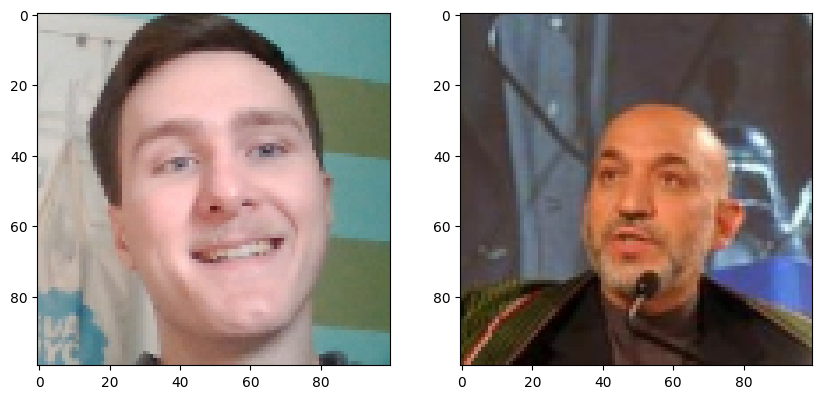

In [40]:
# shows test images from the batch 
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [41]:
# saves the model weights
siamese_model.save('siamesemodelv2.h5')

In [29]:
L1Dist

__main__.L1Dist

In [30]:
# loads model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [44]:
# tests reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


array([[1.90814324e-13],
       [3.40265364e-16],
       [1.00000000e+00],
       [4.88681283e-11],
       [1.11223984e-13],
       [2.96700442e-08],
       [6.86518986e-16],
       [1.07855543e-15],
       [1.00000000e+00],
       [9.97970045e-01],
       [1.47243273e-10],
       [2.96711461e-10],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99997437e-01],
       [9.99999046e-01]], dtype=float32)

In [32]:
# calcs predictions of input/verif. images, checks how many have a prediction num greater than the detection threshold,
# checks how many images are detected with a positive match and returns if the amount is greater than the verif. threshold
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('app_data', 'verification_images')):
        input_img = preprocess(os.path.join('app_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('app_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [46]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('app_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

In [47]:
np.sum(np.squeeze(results) > 0.5)

np.int64(44)

In [48]:
results

[array([[0.999965]], dtype=float32),
 array([[0.99996775]], dtype=float32),
 array([[0.9999926]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.8848325]], dtype=float32),
 array([[0.8223096]], dtype=float32),
 array([[0.1799645]], dtype=float32),
 array([[0.99928933]], dtype=float32),
 array([[0.9998316]], dtype=float32),
 array([[0.9999262]], dtype=float32),
 array([[0.999995]], dtype=float32),
 array([[0.9999956]], dtype=float32),
 array([[0.9999582]], dtype=float32),
 array([[0.999988]], dtype=float32),
 array([[0.9999114]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.99999994]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 arra